In [1]:
%reload_kedro

                    INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=566372;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=622540;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

                    INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=362487;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=399439;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[12/18/23 22:07:53] INFO     Kedro project ModSpy-Data                                              ]8;id=59693;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=904483;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Kedro project ModSpy-Data                                              ]8;id=826792;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=109800;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=9662;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=692201;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=922952;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=558321;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

In [51]:
# -*- coding: utf-8 -*-
# from __future__ import absolute_import, division, print_function, unicode_literals
import random
import logging
import itertools
from rich import print
from IPython.display import display, HTML

import pandas as pd
import numpy as np
from modspy_data.helpers import KnowledgeGraphScores

import matplotlib.pyplot as plt
import seaborn as sns

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress, performance_report
from dask_jobqueue import SLURMCluster


import torch
import pronto
import networkx as nx
# from utils import visualize
from pyvis.network import Network
from sklearn.preprocessing import LabelEncoder
from stellargraph import StellarGraph    # Lovin' it!
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from nxontology import NXOntology
from nxontology.imports import (from_file, multidigraph_to_digraph,
                                pronto_to_multidigraph)
from networkx.drawing.nx_agraph import graphviz_layout
from nxontology.viz import create_similarity_graphviz
from torch_geometric.data import Data, InMemoryDataset, download_url
import torch_geometric.transforms as T
from torch_geometric.utils.convert import from_networkx
from torch.nn import Linear, ModuleList
from torch_geometric.nn import GATConv, GraphConv, MetaPath2Vec
# from torch_geometric.loaders import DataLoader, Dataset
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.utils import convert

In [73]:
jvl = catalog.load('jvl_annotated')
olida = catalog.load('olida_annotated')
mtg = catalog.load('zyg1_annotated')

[12/19/23 01:26:07] INFO     Loading data from 'jvl_annotated' (CSVDataSet)...                  ]8;id=613444;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=144102;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'jvl_annotated' (CSVDataSet)...                  ]8;id=353961;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=141158;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'olida_annotated' (CSVDataSet)...                ]8;id=878041;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=280567;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'olida_annotated' (CSVDataSet)...                ]8;id=726806;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=952470;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'zyg1_annotated' (CSVDataSet)...                 ]8;id=352976;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=43332;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'zyg1_annotated' (CSVDataSet)...                 ]8;id=535029;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=843554;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [74]:
olida = olida[olida['Oligogenic Effect']!='Monogenic+Modifier']

In [75]:
print(olida['Oligogenic Effect'].value_counts())
print(olida.shape)

True Digenic                47
Dual Molecular Diagnosis    28
Name: Oligogenic Effect, dtype: int64

(75, 47)

In [76]:
# Adding source column
jvl['source'] = 'JVL'
olida['source'] = 'OLIDA'
mtg['source'] = 'MTG'

# Classification labels
jvl['is_modifier'] = 1
olida['is_modifier'] = 0

# Rename columns to indicate same information
jvl.rename(columns={'QueryGene': 'target_gene', 'SuppressorGene': 'modifier_gene'}, inplace=True)
olida.rename(columns={'gene_a': 'target_gene', 'gene_b': 'modifier_gene'}, inplace=True)
mtg.rename(columns={'gene_symbol': 'modifier_gene', 'target_gene_symbol': 'target_gene'}, inplace=True)


In [77]:
dataset_df = pd.concat([jvl, olida, mtg])
print(dataset_df.shape)
print(dataset_df['source'].value_counts())

(8337, 218)

MTG      7330
JVL       932
OLIDA      75
Name: source, dtype: int64

In [67]:
list(dataset_df.columns)

['PubmedID',
 'Category',
 'Tissue',
 'target_gene',
 'QueryFunction',
 'QueryMutation',
 'QueryType',
 'modifier_gene',
 'SuppressorFunction',
 'SuppressorMutation',
 'SNP_ID',
 'SuppressorType',
 'EffectSize',
 'Disease',
 'DiseaseSubType',
 'CellLineIdentified',
 'ModelSystemValidated',
 'Drugs',
 'target_GOs',
 'target_GOs_count',
 'modifier_GOs',
 'modifier_GOs_count',
 'target_POs',
 'target_POs_count',
 'modifier_POs',
 'modifier_POs_count',
 'target_DOs',
 'target_DOs_count',
 'modifier_DOs',
 'modifier_DOs_count',
 'source',
 'is_modifier',
 'Entry Id',
 'Genes',
 'Genes Relationship',
 'Protein Interactions',
 'Common Pathways',
 'GENEmeta_x',
 'Oligogenic variant combinations',
 'olida_id',
 'OLIDA ID',
 'Omim Id',
 'Diseases',
 'Oligogenic Effect',
 'Ethnicity',
 'References',
 'Associated Variants',
 'FAMmanual',
 'STATmanual',
 'STATknowledge',
 'STATmeta',
 'GENEmanual',
 'GENEmanual harmonized',
 'GENEknowledge',
 'GENEmeta_y',
 'VARmanual',
 'VARknowledge',
 'VARmeta',

In [115]:
olida[['target_GOs','modifier_GOs']]

,target_GOs,modifier_GOs
1,"GO:0005080,GO:0005200,GO:0005516,GO:0007010,GO...","GO:0000977,GO:0003682,GO:0003712,GO:0003712,GO..."
3,"GO:0071407,GO:0004497,GO:0004497,GO:0004497,GO...","GO:0051897,GO:0070374,GO:0001725,GO:0005884,GO..."
4,"GO:0005243,GO:0005243,GO:0005509,GO:0005515,GO...","GO:0006883,GO:0004252,GO:0004252,GO:0017080,GO..."
6,"GO:0005515,GO:0005515,GO:0005515,GO:0005515,GO...","GO:0002153,GO:0002153,GO:0006357,GO:1990904,GO..."
10,"GO:0003779,GO:0005515,GO:0005515,GO:0005515,GO...","GO:0003723,GO:0005164,GO:0005515,GO:0005515,GO..."
...,...,...
129,"GO:0005524,GO:0016887,GO:0120020,GO:0005515,GO...","GO:0003723,GO:0004252,GO:0005515,GO:0005515,GO..."
130,"GO:0001540,GO:0001540,GO:0001540,GO:0005041,GO...","GO:0003723,GO:0004252,GO:0005515,GO:0005515,GO..."
135,"GO:0000122,GO:0010628,GO:0010628,GO:0010628,GO...","GO:0000976,GO:0003682,GO:0005515,GO:0005515,GO..."
136,"GO:0030509,GO:0005179,GO:0005515,GO:0005515,GO...","GO:0003677,GO:0003714,GO:0005515,GO:0005515,GO..."


In [78]:
# Reordering important columns
desired_first_columns = ['source', 'target_gene', 'modifier_gene', 'is_modifier'] 
remaining_columns = [col for col in dataset_df.columns if col not in desired_first_columns]
new_column_order = desired_first_columns + remaining_columns
dataset_df = dataset_df[new_column_order]
dataset_df.head()


,source,target_gene,modifier_gene,is_modifier,PubmedID,Category,Tissue,QueryFunction,QueryMutation,QueryType,...,wpo_resnik_scaled_bma,wpo_lin_max,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma
0,JVL,APOE,CASP7,1.0,27358062.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/C112R,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JVL,APOE,HBB,1.0,24116184.0,Patients,-,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JVL,APOE,KL,1.0,30867273.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JVL,APOE,KL,1.0,32282020.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JVL,ATR,ETV1,1.0,23284306.0,Cells,-,DNA replication and repair;Signaling & stress ...,silencing/silencing,LOF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
nodes_ddf = catalog.load('monarch_nodes_sample')

[12/19/23 01:28:44] INFO     Loading data from 'monarch_nodes_sample' (DaskDataFrameDataSet)... ]8;id=369462;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=734048;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_nodes_sample' (DaskDataFrameDataSet)... ]8;id=45962;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=908918;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [84]:
all_genes = np.union1d(dataset_df['target_gene'], dataset_df['modifier_gene'])
all_genes.shape 

(5773,)

In [85]:
ndf = nodes_ddf.dropna(subset=['symbol', 'in_taxon'], how='any')

In [90]:
selected_nodes = ndf[((ndf['in_taxon']=='NCBITaxon:9606')|(ndf['in_taxon']=='NCBITaxon:6239')) & (ndf['symbol'].isin(all_genes))]

In [92]:
sel_nodes = selected_nodes.compute()

In [93]:
sel_nodes.shape

(460, 16)

In [97]:
sel_nodes['in_taxon_label'].value_counts()

Caenorhabditis elegans    236
Homo sapiens              224
Name: in_taxon_label, dtype: int64

# Monarch Embedding

In [3]:
nodes = catalog.load('monarch_nodes_sample').compute()
edges = catalog.load('monarch_edges_sample').compute()

[12/18/23 22:08:02] INFO     Loading data from 'monarch_nodes_sample' (DaskDataFrameDataSet)... ]8;id=264955;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=963123;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_nodes_sample' (DaskDataFrameDataSet)... ]8;id=554358;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=980304;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_edges_sample' (DaskDataFrameDataSet)... ]8;id=440516;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=299743;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_edges_sample' (DaskDataFrameDataSet)... ]8;id=975983;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=54822;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [12]:
node_cleaned = nodes[['id','category']]
edge_cleaned = edges[['subject','object','predicate','category']]

# String to Numeric for edge feat
le = LabelEncoder()
edge_cleaned['predicate'] = le.fit_transform(edge_cleaned['predicate'])

[12/18/23 22:37:59] WARNING  /tmp/ipykernel_2438/709283697.py:5: SettingWithCopyWarning:            ]8;id=548962;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=695019;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               edge_cleaned['predicate'] =                                                         
                             le.fit_transform(edge_cleaned['predicate'])                                           
                                                                                                                   

In [28]:
# Assuming `nodes` is your nodes DataFrame and `edges` is your edges DataFrame
# and both have a 'category' column

# Create a dictionary of node types
node_type_mapping = {row['id']: row['category'] for _, row in node_cleaned.iterrows()}
# _nc = _nc['']
mapped_nodes = {node_type: node_cleaned[node_cleaned['category'] == node_type].drop(columns='category').set_index("id") for node_type in node_type_mapping.values()}
# mapped_nodes = {node_type: node_cleaned[node_cleaned['category'] == node_type].set_index("id").droplevel('category', axis=1) for node_type in node_type_mapping.values()}
# display(node_type_mapping)
# display(mapped_nodes)

In [29]:
mapped_nodes['biolink:Gene']

""
id
PomBase:SPAC105.02c
PomBase:SPAC110.02
PomBase:SPAC11H11.04
PomBase:SPAC1296.01c
PomBase:SPAC12G12.11c
...
HGNC:4929
HGNC:12978
HGNC:33517


In [18]:
# Assuming `df` is your DataFrame, `key_column` is the column you want to use as keys,
# and `value_column` is the column you want to use as values
node_dict = node_cleaned.set_index('id')['id'].apply(list).to_dict()
node_dict

{'biolink:AnatomicalEntity': ['EMAPA:16059',
  'EMAPA:16092',
  'EMAPA:16103',
  'EMAPA:16104',
  'EMAPA:16140',
  'EMAPA:16180',
  'EMAPA:16192',
  'EMAPA:16382',
  'EMAPA:16388',
  'EMAPA:16406',
  'EMAPA:16469',
  'EMAPA:16659',
  'EMAPA:16660',
  'EMAPA:16668',
  'EMAPA:16681',
  'EMAPA:16727',
  'EMAPA:16795',
  'EMAPA:16797',
  'EMAPA:16799',
  'EMAPA:16800',
  'EMAPA:16805',
  'EMAPA:17074',
  'EMAPA:17213',
  'EMAPA:17251',
  'EMAPA:17366',
  'EMAPA:17381',
  'EMAPA:17382',
  'EMAPA:17524',
  'EMAPA:17544',
  'EMAPA:17546',
  'EMAPA:17569',
  'EMAPA:17571',
  'EMAPA:17576',
  'EMAPA:17608',
  'EMAPA:17755',
  'EMAPA:17796',
  'EMAPA:17838',
  'EMAPA:17968',
  'EMAPA:18226',
  'EMAPA:18438',
  'EMAPA:18590',
  'EMAPA:18765',
  'EMAPA:19155',
  'EMAPA:19157',
  'EMAPA:19303',
  'EMAPA:31488',
  'EMAPA:31527',
  'EMAPA:32665',
  'EMAPA:32672',
  'EMAPA:32673',
  'EMAPA:32703',
  'EMAPA:32712',
  'EMAPA:32841',
  'EMAPA:32857',
  'EMAPA:35223',
  'EMAPA:35237',
  'EMAPA:35255',
  '

In [ ]:
# # Create a dictionary of node types
# edge_type_mapping = {row['id']: row['category'] for _, row in node_cleaned.iterrows()}
# mapped_nodes = {node_type: node_cleaned[node_cleaned['category'] == node_type].drop(columns='category').set_index("id") for node_type in node_type_mapping.values()}


In [31]:
edge_cleaned = edge_cleaned.rename(columns={'subject': 'source', 'object': 'target'})

In [41]:
list(mapped_nodes.keys())
# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ['biolink:Gene', "biolink:MolecularEntity", 'biolink:Gene'],
    ['biolink:Gene', "biolink:SmallMolecule", 'biolink:Gene'],
    ['biolink:Gene', "biolink:ChemicalEntity", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Cell", 'biolink:Gene'],
    ['biolink:Gene', "biolink:PhenotypicFeature", 'biolink:Gene'],
    ['biolink:Gene', "biolink:BiologicalProcessOrActivity", 'biolink:Gene'],
    ['biolink:Gene', "biolink:CellularComponent", 'biolink:Gene'],
    ['biolink:Gene', "biolink:LifeStage", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Disease", 'biolink:Gene'],
    ['biolink:Gene', "biolink:PhenotypicQuality", 'biolink:Gene'],
    ['biolink:Gene', "biolink:CellularOrganism", 'biolink:Gene'],
    ['biolink:Gene', "biolink:PathologicalProcess", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Pathway", 'biolink:Gene'],
    ['biolink:Gene', "biolink:Pathway", 'biolink:Gene'],
]


In [38]:
edge_cats = edge_cleaned['category'].unique()
edge_cats

array(['biolink:DiseaseToPhenotypicFeatureAssociation',
       'biolink:GeneToPhenotypicFeatureAssociation',
       'biolink:CausalGeneToDiseaseAssociation',
       'biolink:CorrelatedGeneToDiseaseAssociation',
       'biolink:PairwiseGeneToGeneInteraction',
       'biolink:GeneToPathwayAssociation',
       'biolink:GeneToExpressionSiteAssociation',
       'biolink:MacromolecularMachineToCellularComponentAssociation',
       'biolink:MacromolecularMachineToMolecularActivityAssociation',
       'biolink:MacromolecularMachineToBiologicalProcessAssociation',
       'biolink:GeneToGeneHomologyAssociation', 'biolink:Association',
       'biolink:ChemicalToPathwayAssociation',
       'biolink:DiseaseOrPhenotypicFeatureToGeneticInheritanceAssociation'],
      dtype=object)

In [ ]:
edge_cat

In [32]:
monarch_graph = StellarGraph(
    nodes=mapped_nodes,
    edges=edge_cleaned, edge_type_column="category"
)

In [42]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

from stellargraph.data import UniformRandomMetaPathWalk

# Create the random walker
rw = UniformRandomMetaPathWalk(monarch_graph)

walks = rw.run(
    nodes=list(monarch_graph.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))


Number of random walks: 185136

In [46]:
from gensim.models import Word2Vec

model = Word2Vec(walks, vector_size=128, window=5, min_count=0, sg=1, workers=2, epochs=1)
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(15553, 128)

In [49]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [monarch_graph.node_type(node_id) for node_id in node_ids]


In [107]:
node_targets[:5]

['biolink:BiologicalProcessOrActivity',
 'biolink:CellularComponent',
 'biolink:CellularComponent',
 'biolink:CellularComponent',
 'biolink:CellularComponent']

In [110]:
transform = TSNE  # PCA

_trans = transform(n_components=3)
node_embeddings_2d = _trans.fit_transform(node_embeddings)
node_embeddings_2d

[12/19/23 02:20:42] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/manifold/_ ]8;id=270062;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=697922;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             t_sne.py:800: FutureWarning: The default initialization in TSNE will                  
                             change from 'random' to 'pca' in 1.2.                                                 
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/manifold/_ ]8;id=485869;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=942727;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             t_sne.py:810: FutureWarning: The default learning rate in TSNE will                   
                             change from 200.0 to 'auto' in 1.2.                                                   
                               warnings.warn(                                                                      
                                                                                                                   

array([[ 30.67747   , -27.158731  ,  19.294094  ],
       [-34.357643  ,  10.107448  ,  17.585546  ],
       [ 35.595924  ,   7.0996003 ,  20.801296  ],
       ...,
       [ 11.623435  ,  -0.89443594,  14.156     ],
       [ 23.399683  ,  -5.8433504 ,   1.6714528 ],
       [-16.901148  ,  25.898563  , -14.675956  ]], dtype=float32)

In [111]:
from mpl_toolkits.mplot3d import Axes3D

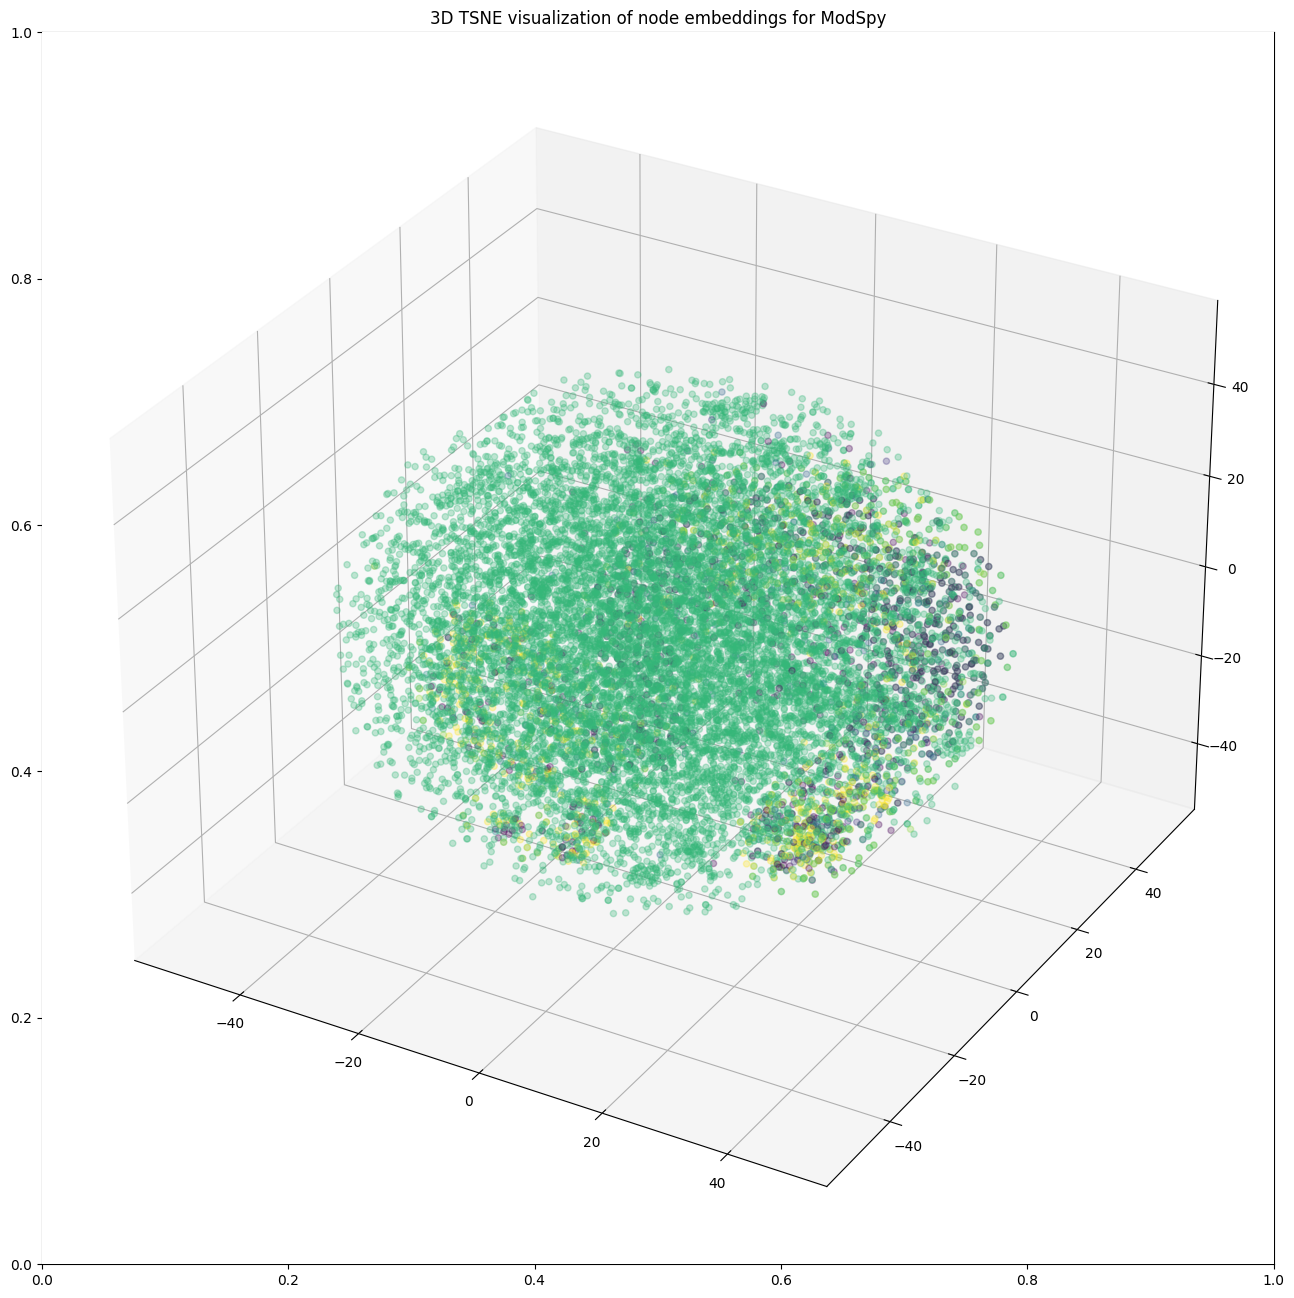

In [112]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

fig = plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], node_embeddings_2d[:, 2], c=node_colours, alpha=0.3)
plt.title("3D {} visualization of node embeddings for ModSpy".format(transform.__name__))
plt.show()

In [52]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

[12/19/23 00:58:44] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/manifold/_ ]8;id=269421;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=333679;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             t_sne.py:800: FutureWarning: The default initialization in TSNE will                  
                             change from 'random' to 'pca' in 1.2.                                                 
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/sklearn/manifold/_ ]8;id=770276;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=612605;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             t_sne.py:810: FutureWarning: The default learning rate in TSNE will                   
                             change from 200.0 to 'auto' in 1.2.                                                   
                               warnings.warn(                                                                      
                                                                                                                   

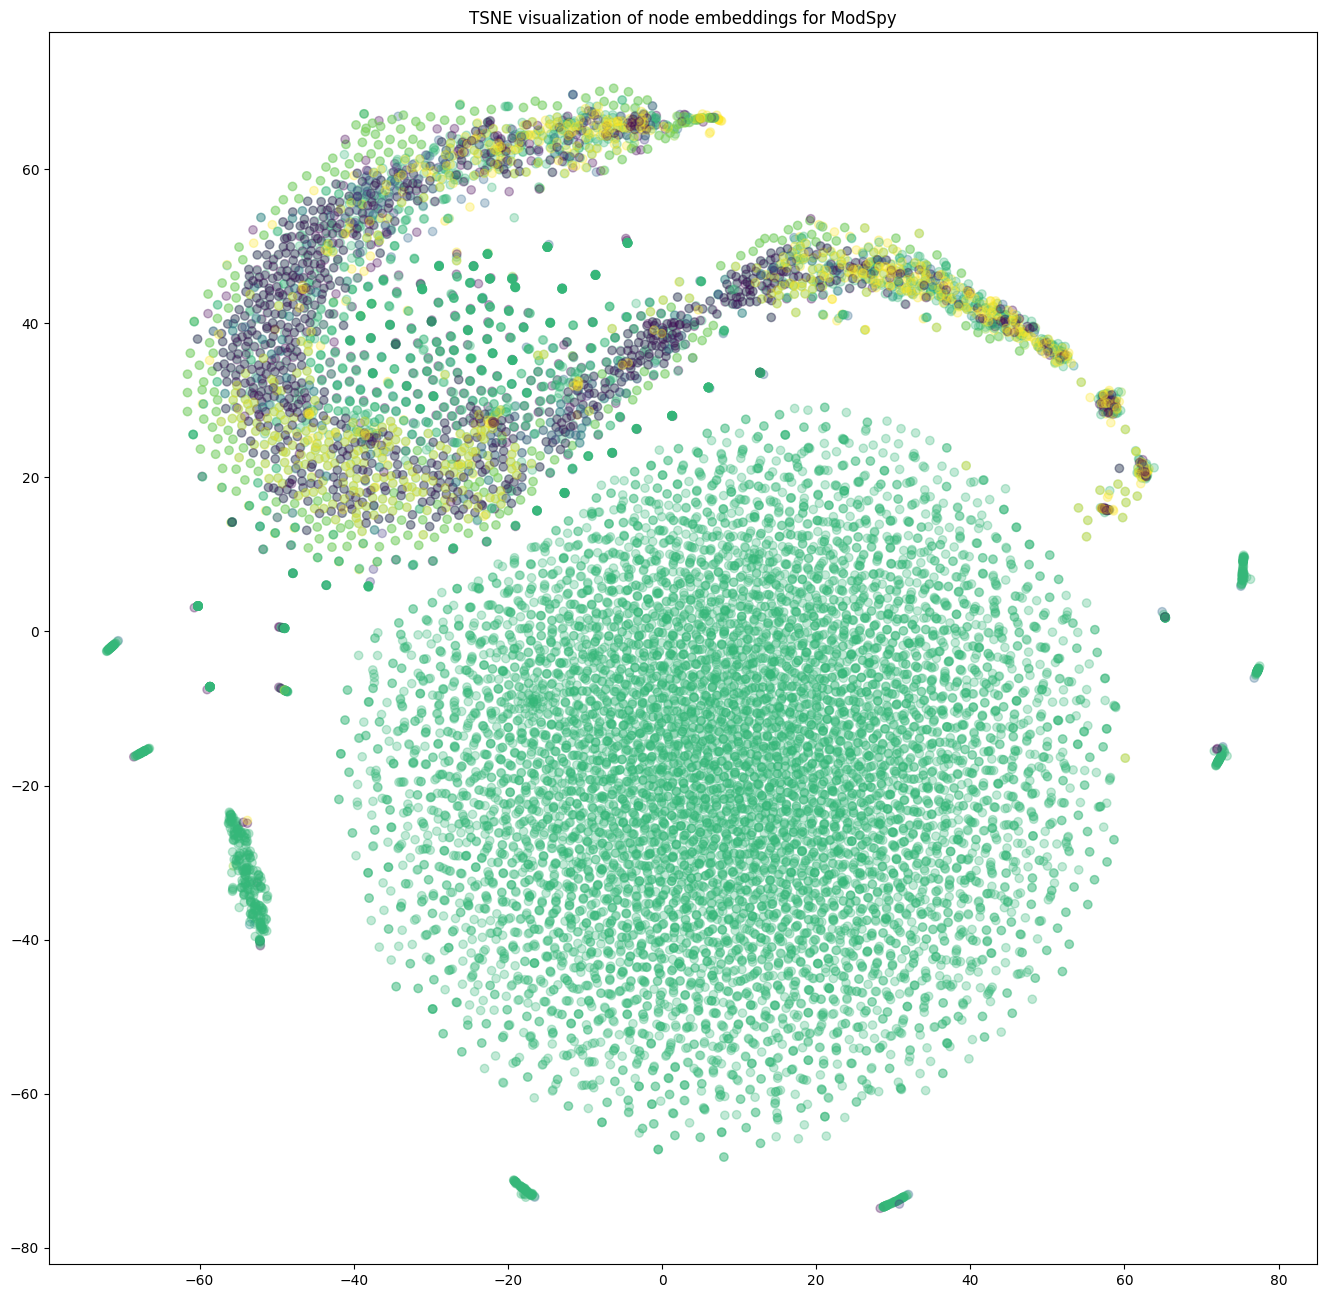

In [54]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("{} visualization of node embeddings for ModSpy".format(transform.__name__))
plt.show()

In [35]:
# print(monarch_graph.info())

In [ ]:
square_orientation_weighted = StellarGraph(
    {"foo": square_foo, "bar": square_bar}
    edges=edges[['subject', 'object', 'category']], edge_type_column="category"
)
print(square_orientation_weighted.info())

In [27]:
# Create a directed multigraph
G = nx.MultiDiGraph()

# Add nodes to the graph
for _, row in nodes.iterrows():
    node_id = row['id']
    node_attr = row.to_dict()
    # node_attr = row[['category']].to_dict()
    G.add_node(node_id, **node_attr)

# Add edges to the graph
for _, row in edges.iterrows():
    subject = row['subject']
    object_ = row['object']
    edge_attr = row.to_dict()
    # edge_attr = row[['category']].to_dict()
    G.add_edge(subject, object_, **edge_attr)

# Information about the created graph
graph_info = nx.info(G)
graph_info


[12/18/23 20:00:41] WARNING  /tmp/ipykernel_238946/270064704.py:20: DeprecationWarning: info is     ]8;id=183910;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=317036;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             deprecated and will be removed in version 3.0.                                        
                                                                                                                   
                               graph_info = nx.info(G)                                                             
                                                                                                                   

'MultiDiGraph with 18033 nodes and 11410 edges'

In [29]:
# Select 1000 random nodes
random_nodes = random.sample(G.nodes(), 1000, seed=100)

# Create a subgraph with these nodes
subgraph = G.subgraph(random_nodes)

# Information about the created subgraph
subgraph_info = nx.info(subgraph)
subgraph_info


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 # Select 1000 random nodes                                                                  │
│ ❱  2 random_nodes = random.sample(G.nodes(), 1000, seed=100)                                     │
│    3                                                                                             │
│    4 # Create a subgraph with these nodes                                                        │
│    5 subgraph = G.subgraph(random_nodes)                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: sample() got an unexpected keyword argument 'seed'

In [25]:

# Create a PyVis Network object
net = Network(directed=True, notebook=True)

# Convert NetworkX graph to PyVis format
net.from_nx(subgraph)

net.show('monarch-kg-sample.html')

In [26]:
# Extract unique categories of nodes and edges
node_categories = set(nx.get_node_attributes(subgraph, 'category').values())
edge_categories = set(nx.get_edge_attributes(subgraph, 'category').values())

# Assign a unique color to each category
node_color_map = {category: plt.cm.tab20(i) for i, category in enumerate(node_categories)}
edge_color_map = {category: plt.cm.Paired(i) for i, category in enumerate(edge_categories)}

# Prepare color for each node and edge
node_colors = [node_color_map[subgraph.nodes[node]['category']] for node in subgraph.nodes()]
edge_colors = [edge_color_map[subgraph.edges[edge]['category']] for edge in subgraph.edges()]

# Correcting the extraction of edge categories for a MultiDiGraph
edge_colors = []
for u, v, key in subgraph.edges(keys=True):
    category = subgraph[u][v][key]['category']
    edge_colors.append(edge_color_map.get(category, 'black'))  # Default to black if category not found


# Redefine the legends for node and edge categories
node_patches = [plt.Line2D([0], [0], marker='o', color='w', label=category, markersize=10, markerfacecolor=color) for category, color in node_color_map.items()]
edge_patches = [plt.Line2D([0], [0], color=color, label=category, linewidth=2) for category, color in edge_color_map.items()]

pos = nx.spring_layout(subgraph)

# Redrawing the subgraph with corrected edge colors and legends
plt.figure(figsize=(12, 12))
nx.draw(subgraph, pos, node_size=20, node_color=node_colors, edge_color=edge_colors, with_labels=False)
plt.legend(handles=node_patches, title='Node Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(handles=edge_patches, title='Edge Categories', bbox_to_anchor=(1.05, 0.5), loc='upper left')
plt.title("Subgraph Visualization with Different Colors for Node and Edge Categories")
plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8                                                                                             │
│    9 # Prepare color for each node and edge                                                      │
│   10 node_colors = [node_color_map[subgraph.nodes[node]['category']] for node in subgraph.nod    │
│ ❱ 11 edge_colors = [edge_color_map[subgraph.edges[edge]['category']] for edge in subgraph.edg    │
│   12                                                                                             │
│   13 # Correcting the extraction of edge categories for a MultiDiGraph                           │
│   14 edge_colors = []                                                                            │
│                                                                                                  │
│ in <listcomp>:11                                                                                 │
│                                                                                                  │
│    8                                                                                             │
│    9 # Prepare color for each node and edge                                                      │
│   10 node_colors = [node_color_map[subgraph.nodes[node]['category']] for node in subgraph.nod    │
│ ❱ 11 edge_colors = [edge_color_map[subgraph.edges[edge]['category']] for edge in subgraph.edg    │
│   12                                                                                             │
│   13 # Correcting the extraction of edge categories for a MultiDiGraph                           │
│   14 edge_colors = []                                                                            │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/networkx/classes/reportviews.py:1361 in      │
│ __getitem__                                                                                      │
│                                                                                                  │
│   1358 │   │   │   │   f"{type(self).__name__} does not support slicing, "                       │
│   1359 │   │   │   │   f"try list(G.edges)[{e.start}:{e.stop}:{e.step}]"                         │
│   1360 │   │   │   )                                                                             │
│ ❱ 1361 │   │   u, v, k = e                                                                       │
│   1362 │   │   return self._adjdict[u][v][k]                                                     │
│   1363 │                                                                                         │
│   1364 │   def __call__(self, nbunch=None, data=False, keys=False, default=None):                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: not enough values to unpack (expected 3, got 2)

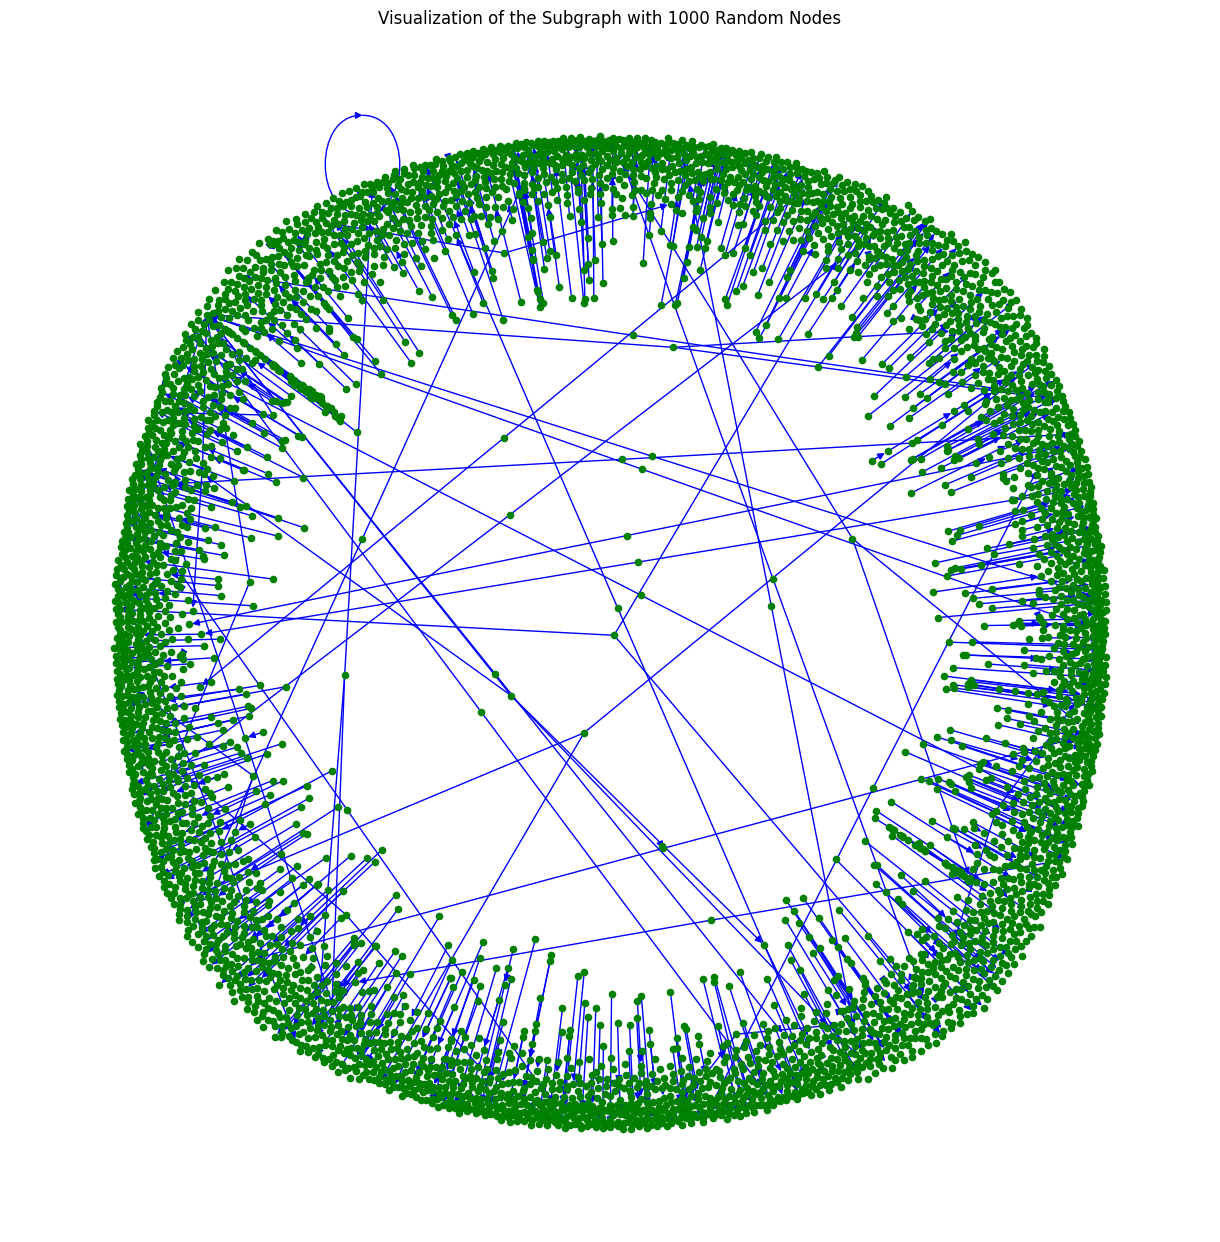

In [7]:
# Set the figure size for the visualization
plt.figure(figsize=(12, 12))

# Draw the subgraph
# Note: The layout is set to 'spring_layout' for aesthetic purposes, but this can be changed as needed.
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_size=20, edge_color='blue', node_color='green', with_labels=False)

# Show the plot
plt.title("Visualization of the Subgraph with 1000 Random Nodes")
plt.show()

In [ ]:
net = Network()

In [2]:
def convert_to_networkx_multidigraph(hetero_data):
    G = nx.MultiDiGraph()

    # Add nodes with attributes
    for node_type, node_data in hetero_data.x_dict.items():
        for node_id in range(node_data.size(0)):
            G.add_node((node_type, node_id), **{'type': node_type})

    # Add edges with attributes
    for edge_type, edge_index in hetero_data.edge_index_dict.items():
        for i in range(edge_index.size(1)):
            source = (edge_type[0], edge_index[0, i].item())
            target = (edge_type[2], edge_index[1, i].item())
            # If there are edge attributes, add them here
            edge_attr = {}  # Replace with actual edge attributes if available
            G.add_edge(source, target, key=edge_type[1], **edge_attr)

    return G

# Example: Convert your HeteroData object
G = convert_to_networkx_multidigraph(data)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:21                                                                                   │
│                                                                                                  │
│   18 │   return G                                                                                │
│   19                                                                                             │
│   20 # Example: Convert your HeteroData object                                                   │
│ ❱ 21 G = convert_to_networkx_multidigraph(data)                                                  │
│   22                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'data' is not defined

In [ ]:
G = nx.MultiDiGraph()


In [17]:

import os.path as osp


In [19]:
from torch_geometric.datasets import AMiner
path = osp.join('./data/AMiner')
dataset = AMiner(path)
data = dataset[0]

Extracting data/AMiner/net_aminer.zip
Extracting data/AMiner/raw/label.zip
Processing...
Done!


In [20]:

metapath = [
    ('author', 'writes', 'paper'),
    ('paper', 'published_in', 'venue'),
    ('venue', 'publishes', 'paper'),
    ('paper', 'written_by', 'author'),
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,
                     metapath=metapath, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

[12/18/23 14:40:05] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/utils/data/d ]8;id=386651;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=470464;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ataloader.py:554: UserWarning: This DataLoader will create 6 worker                   
                             processes in total. Our suggested max number of worker in current                     
                             system is 1, which is smaller than what this DataLoader is going to                   
                             create. Please be aware that excessive worker creation might get                      
                             DataLoader running slow or even freeze, lower the worker number to                    
                             avoid potential slowness/freeze if necessary.                                         
                               warnings.warn(_create_warning_msg(                                                  
                                                                                                                   

In [24]:

for i, (pos_rw, neg_rw) in enumerate(loader):
    print(pos_rw)
    print(neg_rw)
    if i == 3:
        break
print(len(list(enumerate(loader))))

[12/18/23 15:07:11] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/utils/data/d ]8;id=186274;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=507629;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ataloader.py:554: UserWarning: This DataLoader will create 6 worker                   
                             processes in total. Our suggested max number of worker in current                     
                             system is 1, which is smaller than what this DataLoader is going to                   
                             create. Please be aware that excessive worker creation might get                      
                             DataLoader running slow or even freeze, lower the worker number to                    
                             avoid potential slowness/freeze if necessary.                                         
                               warnings.warn(_create_warning_msg(                                                  
                                                                                                                   

tensor([[1447655, 4073974, 4888819,  ...,  544784, 2261652, 4888018],
        [ 170474, 4471730, 4888803,  ...,  110272, 3230486, 4890583],
        [1567523, 4436543, 4891255,  ...,  117255, 2960739, 4890797],
        ...,
        [1063320, 4149125, 4891519,  ..., 1024112, 4381470, 4889880],
        [ 151410, 4176628, 4891229,  ...,   99529, 4177137, 4891229],
        [ 408161, 4563940, 4888860,  ...,   53966, 2548785, 4888011]])

tensor([[1447655, 4063019, 4889979,  ...,  290844, 1727691, 4889404],
        [ 170474, 1979224, 4891138,  ...,  272707, 4556994, 4890987],
        [1567523, 2412331, 4889616,  ...,  531889, 2827018, 4889404],
        ...,
        [ 736525, 4062536, 4888143,  ..., 1655618, 2497389, 4889726],
        [1489312, 4690157, 4888446,  ...,  185429, 3468695, 4888612],
        [ 223272, 2624183, 4890457,  ...,  916994, 3361243, 4890167]])

tensor([[1231148, 3498607, 4888472,  ...,  110999, 2110338, 4889806],
        [ 837240, 2685425, 4888774,  ...,  368212, 4379139, 4890216],
        [ 350600, 2007341, 4887961,  ...,  212168, 2349124, 4891189],
        ...,
        [ 335307, 3318854, 4888731,  ...,  485535, 4470982, 4888803],
        [ 457540, 3394849, 4888977,  ...,  441260, 3414783, 4890171],
        [  79929, 1745609, 4889687,  ...,   79108, 3647273, 4888185]])

tensor([[1231148, 2274744, 4891177,  ...,  978045, 3083560, 4890729],
        [ 837240, 2711500, 4888179,  ...,  733220, 2910624, 4890730],
        [ 350600, 1958827, 4889142,  ..., 1623754, 2177548, 4891442],
        ...,
        [ 772857, 2344089, 4890100,  ..., 1174875, 3810015, 4888496],
        [  70798, 3433635, 4890059,  ...,  889235, 3838079, 4889787],
        [ 442490, 2743304, 4889605,  ..., 1364236, 4215866, 4888407]])

tensor([[ 516060, 2219560, 4890811,  ...,   13058, 3463822, 4888410],
        [ 508570, 2939215, 4888690,  ...,   46413, 3658764, 4888185],
        [ 919120, 3350526, 4891404,  ..., 1157122, 3350287, 4891404],
        ...,
        [ 103751, 3767916, 4890992,  ...,   19144, 3293120, 4891098],
        [ 101512, 1965296, 4890674,  ...,    3709, 4789171, 4888719],
        [  40402, 3068905, 4891468,  ...,  454591, 2142602, 4890377]])

tensor([[ 516060, 3495826, 4891724,  ...,  357287, 4638780, 4891249],
        [ 508570, 3061922, 4888736,  ...,  663601, 4304193, 4889672],
        [ 919120, 1755954, 4889397,  ...,  656539, 1998277, 4889143],
        ...,
        [1427228, 3850704, 4889881,  ..., 1336873, 4634833, 4891598],
        [ 115982, 2966627, 4889107,  ...,  335892, 4350242, 4888788],
        [ 936629, 2063699, 4890771,  ..., 1484186, 3118987, 4891386]])

tensor([[1414283, 3981684, 4891655,  ...,  201499, 3230489, 4890583],
        [ 155375, 3331832, 4889646,  ...,    1543, 3599349, 4891316],
        [ 199985, 1842241, 4890982,  ...,   41884, 1843127, 4890982],
        ...,
        [  13383, 2456711, 4888092,  ...,  254440, 2456853, 4888092],
        [ 304884, 3385075, 4889139,  ..., 1177315, 3387460, 4889139],
        [  19884, 4639605, 4888978,  ..., 1005260, 4316186, 4891100]])

tensor([[1414283, 2995345, 4888744,  ...,   50674, 2651241, 4891444],
        [ 155375, 2313129, 4889408,  ..., 1268602, 4076657, 4890098],
        [ 199985, 3749450, 4891383,  ..., 1086131, 1947891, 4888128],
        ...,
        [ 485441, 1857516, 4889646,  ...,  945244, 2943425, 4891261],
        [1307787, 2095635, 4890633,  ..., 1324631, 2415458, 4888339],
        [ 514689, 2407330, 4891299,  ..., 1026443, 3307917, 4889501]])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:1120 in       │
│ _try_get_data                                                                                    │
│                                                                                                  │
│   1117 │   │   # Returns a 2-tuple:                                                              │
│   1118 │   │   #   (bool: whether successfully get data, any: data if successful else None)      │
│   1119 │   │   try:                                                                              │
│ ❱ 1120 │   │   │   data = self._data_queue.get(timeout=timeout)                                  │
│   1121 │   │   │   return (True, data)                                                           │
│   1122 │   │   except Exception as e:                                                            │
│   1123 │   │   │   # At timeout and error, we manually check whether any worker has              │
│                                                                                                  │
│ /cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/multi │
│ processing/queues.py:116 in get                                                                  │
│                                                                                                  │
│   113 │   │   │   finally:                                                                       │
│   114 │   │   │   │   self._rlock.release()                                                      │
│   115 │   │   # unserialize the data after having released the lock                              │
│ ❱ 116 │   │   return _ForkingPickler.loads(res)                                                  │
│   117 │                                                                                          │
│   118 │   def qsize(self):                                                                       │
│   119 │   │   # Raises NotImplementedError on Mac OSX because of broken sem_getvalue()           │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/multiprocessing/reductions.py:100 in   │
│ rebuild_tensor                                                                                   │
│                                                                                                  │
│    97                                                                                            │
│    98 def rebuild_tensor(cls, storage, metadata):                                                │
│    99 │   storage_offset, size, stride, requires_grad = metadata                                 │
│ ❱ 100 │   t = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)                │
│   101 │   if cls == torch.nn.parameter.Parameter:                                                │
│   102 │   │   # we have to pass requires_grad into constructor, rather than set it as an         │
│   103 │   │   # attribute later, because it's an important check for Integer Tensors to          │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/_utils.py:147 in _rebuild_tensor       │
│                                                                                                  │
│   144 def _rebuild_tensor(storage, storage_offset, size, stride):                                │
│   145 │   # first construct a tensor with the correct dtype/device                               │
│   146 │   t = torch.tensor([], dtype=storage.dtype, device=storage.untyped().device)             │
│ ❱ 147 │   return t.set_(storage.untyped(), storage_offset, 

In [4]:
data = catalog.load('monarch_pyg_sample')

[12/18/23 13:46:24] INFO     Loading data from 'monarch_pyg_sample' (TorchFile)...              ]8;id=673347;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=181352;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_pyg_sample' (TorchFile)...              ]8;id=64910;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=192744;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [ ]:
from torch_geometric.utils import 

# Suppose 'data' is your HeteroData graph
# and 'meta_path' is a list of edge types you want to follow

# Example meta_path: ['edge_type1', 'edge_type2', ...]
# Convert edge indices to a format suitable for random_walk

edge_index_dict = {edge_type: data[edge_type].edge_index for edge_type in meta_path}

# Start nodes for the random walk (randomly chosen or specifically selected)
start_nodes = [...]

# Length of the random walk
walk_length = 10

# Generate positive random walks
positive_walks = []
for start_node in start_nodes:
    walk = random_walk(edge_index_dict, start_node, walk_length, meta_path)
    positive_walks.append(walk)


In [ ]:
# Define your meta-paths
# Example: [['node_type1', 'edge_type1', 'node_type2'], ['node_type2', 'edge_type2', 'node_type3'], ...]
meta_paths = data.edge_types  # Replace with your actual meta-paths

# Instantiate the metapath2vec model
model = MetaPath2Vec(data.edge_index_dict, embedding_dim=512, metapath=meta_paths, walk_length=800, context_size=20, walks_per_node=100, num_negative_samples=100)

loader = model.loader(batch_size=128, shuffle=True, num_workers=6)
# Train the model (example training loop)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# for epoch in range(100):
#     model.train()
#     optimizer.zero_grad()
#     loss = model.loss(data.x_dict)
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch+1}/{100}, Loss: {loss.item()}')

def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=data['author'].y_index.to(device))
    y = data['author'].y

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=150)


for epoch in range(1, 6):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

In [ ]:

loader = model.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=data['author'].y_index.to(device))
    y = data['author'].y

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=150)


for epoch in range(1, 6):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

In [10]:
data.num_edge_features

{('biolink:Disease', 'biolink:has_phenotype', 'biolink:PhenotypicFeature'): 0,
 ('biolink:Gene', 'biolink:has_phenotype', 'biolink:PhenotypicFeature'): 0,
 ('biolink:Gene', 'biolink:causes', 'biolink:Disease'): 0,
 ('biolink:Gene',
  'biolink:gene_associated_with_condition',
  'biolink:Disease'): 0,
 ('biolink:Gene', 'biolink:interacts_with', 'biolink:Gene'): 0,
 ('biolink:Gene', 'biolink:participates_in', 'biolink:Pathway'): 0,
 ('biolink:Gene', 'biolink:expressed_in', 'biolink:Cell'): 0,
 ('biolink:Gene',
  'biolink:expressed_in',
  'biolink:GrossAnatomicalStructure'): 0,
 ('biolink:Gene', 'biolink:expressed_in', 'biolink:CellularComponent'): 0,
 ('biolink:Gene', 'biolink:expressed_in', 'biolink:AnatomicalEntity'): 0,
 ('biolink:Gene', 'biolink:expressed_in', 'biolink:MacromolecularComplex'): 0,
 ('biolink:Gene', 'biolink:expressed_in', 'biolink:NamedThing'): 0,
 ('biolink:Gene', 'biolink:located_in', 'biolink:CellularComponent'): 0,
 ('biolink:Gene', 'biolink:enables', 'biolink:Biol

In [7]:
print("===========NODE TYPES=========")
print(data.node_types)
print("===========EDGE TYPES=========")
print(data.edge_types)

===========NODE TYPES=========

[
    'biolink:Gene',
    'biolink:Pathway',
    'biolink:NamedThing',
    'biolink:MolecularEntity',
    'biolink:SmallMolecule',
    'biolink:ChemicalEntity',
    'biolink:Protein',
    'biolink:Cell',
    'biolink:GrossAnatomicalStructure',
    'biolink:AnatomicalEntity',
    'biolink:PhenotypicFeature',
    'biolink:BiologicalProcessOrActivity',
    'biolink:MacromolecularComplex',
    'biolink:CellularComponent',
    'biolink:LifeStage',
    'biolink:Disease',
    'biolink:PhenotypicQuality',
    'biolink:PathologicalProcess',
    'biolink:Vertebrate',
    'biolink:Virus',
    'biolink:CellularOrganism'
]

===========EDGE TYPES=========

[
    ('biolink:Disease', 'biolink:has_phenotype', 'biolink:PhenotypicFeature'),
    ('biolink:Gene', 'biolink:has_phenotype', 'biolink:PhenotypicFeature'),
    ('biolink:Gene', 'biolink:causes', 'biolink:Disease'),
    ('biolink:Gene', 'biolink:gene_associated_with_condition', 'biolink:Disease'),
    ('biolink:Gene', 'biolink:interacts_with', 'biolink:Gene'),
    ('biolink:Gene', 'biolink:participates_in', 'biolink:Pathway'),
    ('biolink:Gene', 'biolink:expressed_in', 'biolink:Cell'),
    ('biolink:Gene', 'biolink:expressed_in', 'biolink:GrossAnatomicalStructure'),
    ('biolink:Gene', 'biolink:expressed_in', 'biolink:CellularComponent'),
    ('biolink:Gene', 'biolink:expressed_in', 'biolink:AnatomicalEntity'),
    ('biolink:Gene', 'biolink:expressed_in', 'biolink:MacromolecularComplex'),
    ('biolink:Gene', 'biolink:expressed_in', 'biolink:NamedThing'),
    ('biolink:Gene', 'biolink:located_in', 'biolink:CellularComponent'),
    ('biolink:Gene', 'biolink:enables', 'biolink:BiologicalProcessOrActivity'),
    ('biolink:Gene', 'biolink:acts_upstream_of_or_within', 'biolink:BiologicalProcessOrActivity'),
    ('biolink:Gene', 'biolink:actively_involved_in', 'biolink:BiologicalProcessOrActivity'),
    ('biolink:Gene', 'biolink:actively_involved_in', 'biolink:Pathway'),
    ('biolink:Gene', 'biolink:part_of', 'biolink:MacromolecularComplex'),
    ('biolink:Gene', 'biolink:contributes_to', 'biolink:BiologicalProcessOrActivity'),
    ('biolink:Gene', 'biolink:acts_upstream_of_or_within', 'biolink:Pathway'),
    ('biolink:Gene', 'biolink:active_in', 'biolink:CellularComponent'),
    ('biolink:Gene', 'biolink:acts_upstream_of', 'biolink:BiologicalProcessOrActivity'),
    ('biolink:Gene', 'biolink:colocalizes_with', 'biolink:CellularComponent'),
    ('biolink:Gene', 'biolink:acts_upstream_of_or_within_positive_effect', 'biolink:BiologicalProcessOrActivity'),
    ('biolink:Gene', 'biolink:orthologous_to', 'biolink:Gene'),
    ('biolink:Cell', 'biolink:related_to', 'biolink:AnatomicalEntity'),
    ('biolink:MolecularEntity', 'biolink:subclass_of', 'biolink:MolecularEntity'),
    ('biolink:AnatomicalEntity', 'biolink:related_to', 'biolink:NamedThing'),
    ('biolink:GrossAnatomicalStructure', 'biolink:related_to', 'biolink:AnatomicalEntity'),
    ('biolink:Cell', 'biolink:related_to', 'biolink:Cell'),
    ('biolink:GrossAnatomicalStructure', 'biolink:subclass_of', 'biolink:AnatomicalEntity'),
    ('biolink:GrossAnatomicalStructure', 'biolink:related_to', 'biolink:GrossAnatomicalStructure'),
    ('biolink:GrossAnatomicalStructure', 'biolink:subclass_of', 'biolink:GrossAnatomicalStructure'),
    ('biolink:GrossAnatomicalStructure', 'biolink:related_to', 'biolink:NamedThing'),
    ('biolink:NamedThing', 'biolink:subclass_of', 'biolink:NamedThing'),
    ('biolink:Cell', 'biolink:related_to', 'biolink:BiologicalProcessOrActivity'),
    ('biolink:Cell', 'biolink:subclass_of', 'biolink:Cell'),
    ('biolink:Cell', 'biolink:related_to', 'biolink:GrossAnatomicalStructure'),
    ('biolink:MolecularEntity', 'biolink:related_to', 'biolink:MolecularEntity'),
    ('biolink:AnatomicalEntity', 'biolink:related_to', 'biolink:GrossAnatomicalStructure'),
    ('biolink:SmallMolecule', 'biolink:subclass_of', 'biolink:MolecularEntity'),
    ('biolink:AnatomicalEntity', 'biolink:related_to', 'biolink:AnatomicalEntity'),
    ('biolink:ChemicalEntity', 'biolink:subclass_of', 'biolink:ChemicalEntity'),
    ('biolink:GrossAnatomicalStructure', 'biolink:related_to', 'biolink:Vertebrate'),
    ('biolink:NamedThing', 'biolink:related_to', 'biolink:NamedThing'),
    ('biolink:Cell', 'biolink:related_to', 'biolink:Protein'),
    ('biolink:AnatomicalEntity', 'biolink:subclass_of', 'biolink:AnatomicalEntity'),
    ('biolink:Cell', 'biolink:related_to', 'biolink:PhenotypicQuality'),
    ('biolink:AnatomicalEntity', 'biolink:related_to', 'biolink:Vertebrate'),
    ('biolink:PhenotypicFeature', 'biolink:related_to', 'biolink:PathologicalProcess'),
    ('biolink:BiologicalP

In [51]:
edges_df = catalog.load('monarch_edges').sample(frac=0.001).compute()
print(edges_df.shape)

[12/17/23 23:29:16] INFO     Loading data from 'monarch_edges' (DaskDataFrameDataSet)...        ]8;id=571720;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=769359;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_edges' (DaskDataFrameDataSet)...        ]8;id=687502;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=287224;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

(11410, 19)

`id` column is better *identifier* for node identity that other columns such as `symbol` . `symbol` could be duplicated across different taxon, NCBI reference.

In [50]:
edges_df[edges['object']=='MONDO:0011488'].shape

(0, 19)

In [52]:
nodes = np.unique(edges_df[['subject', 'object']])
print(len(nodes))

18033

In [53]:
nodes_ddf = catalog.load('monarch_nodes')
nodes_df = nodes_ddf[nodes_ddf['id'].isin(nodes)].compute()

[12/17/23 23:31:40] INFO     Loading data from 'monarch_nodes' (DaskDataFrameDataSet)...        ]8;id=70863;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=583042;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_nodes' (DaskDataFrameDataSet)...        ]8;id=92918;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=377928;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [54]:
display(nodes_df.head())
print(nodes_df.shape)

,id,category,name,xref,provided_by,synonym,full_name,in_taxon,in_taxon_label,symbol,description,deprecated,iri,same_as
41,PomBase:SPAC105.02c,biolink:Gene,ank1,UniProtKB:Q9P7I0,pombase_gene_nodes,NaN,ank1,NCBITaxon:4896,Schizosaccharomyces pombe,ank1,NaN,NaN,NaN,NaN
81,PomBase:SPAC110.02,biolink:Gene,pds5,UniProtKB:Q9HFF5,pombase_gene_nodes,NaN,pds5,NCBITaxon:4896,Schizosaccharomyces pombe,pds5,NaN,NaN,NaN,NaN
137,PomBase:SPAC11H11.04,biolink:Gene,mam2,UniProtKB:Q00619,pombase_gene_nodes,NaN,mam2,NCBITaxon:4896,Schizosaccharomyces pombe,mam2,NaN,NaN,NaN,NaN
146,PomBase:SPAC1296.01c,biolink:Gene,NaN,UniProtKB:Q09770,pombase_gene_nodes,SPAC22F3.01,NaN,NCBITaxon:4896,Schizosaccharomyces pombe,NaN,NaN,NaN,NaN,NaN
178,PomBase:SPAC12G12.11c,biolink:Gene,miy1,UniProtKB:Q09874,pombase_gene_nodes,NaN,miy1,NCBITaxon:4896,Schizosaccharomyces pombe,miy1,NaN,NaN,NaN,NaN


(18033, 14)

In [9]:
m_edge_ddf = catalog.load('monarch_edges')
filt_edge_ddf = m_edge_ddf[(m_edge_ddf['subject'].isin(nodes)) | (m_edge_ddf['object'].isin(nodes))]
edges_df = filt_edge_ddf.compute()

[12/17/23 21:48:47] INFO     Loading data from 'monarch_edges' (DaskDataFrameDataSet)...        ]8;id=484280;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=242777;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_edges' (DaskDataFrameDataSet)...        ]8;id=814002;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=685184;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [58]:
from sklearn.preprocessing import LabelEncoder

# Assuming `df_nodes` is your dataframe and 'category' is the string column
label_encoder = LabelEncoder()
nodes_df['id_encoded'] = label_encoder.fit_transform(nodes_df['id'])
id_tensor = torch.tensor(nodes_df['id_tensor'].values, dtype=torch.long)
edges_df['subject_encoded'] = label_encoder.transform(edges_df['subject'].values)
edges_df['object_encoded'] = label_encoder.transform(edges_df['object'].values)

display(nodes_df[['id','id_encoded']])
display(edges_df[['subject','object','subject_encoded','object_encoded']])

,id,id_encoded
41,PomBase:SPAC105.02c,12342
81,PomBase:SPAC110.02,12343
137,PomBase:SPAC11H11.04,12344
146,PomBase:SPAC1296.01c,12345
178,PomBase:SPAC12G12.11c,12346
...,...,...
223530,ZP:0141180,17885
223631,ZP:0141281,17886
223751,ZP:0141401,17887
224387,ZP:0142037,17888


,subject,object,subject_encoded,object_encoded
188455,MONDO:0008104,HP:0000915,9800,6988
35792,PomBase:SPCC338.08,FYPO:0000268,12556,1953
57423,PomBase:SPBC13G1.10c,FYPO:0000088,12466,1941
36495,PomBase:SPBC2G2.13c,FYPO:0000087,12501,1940
85058,PomBase:SPBC4.04c,FYPO:0000455,12514,1957
...,...,...,...,...
17343,HGNC:12640,HGNC:8974,4008,6659
54232,HGNC:7795,HGNC:1974,6502,4753
104879,HGNC:30528,HGNC:21648,5692,4942
44699,HGNC:12562,HGNC:17270,3995,4516


In [ ]:

# Assuming `df_nodes` is your dataframe and 'category' is the string column
category_encoder = LabelEncoder()
nodes_df['category_encoded'] = category_encoder.fit_transform(nodes_df['category'])
node_category_tensor = torch.tensor(nodes_df['category_tensor'].values, dtype=torch.long)
edges_df['subject_encoded'] = label_encoder.transform(edges_df['subject'].values)
edges_df['object_encoded'] = label_encoder.transform(edges_df['object'].values)

display(nodes_df[['id','id_encoded']])
display(edges_df[['subject','object','subject_encoded','object_encoded']])

In [66]:
print(nodes_df['category'].unique())
print(edges_df['category'].unique())


['biolink:Gene' 'biolink:Pathway' 'biolink:NamedThing'
 'biolink:MolecularEntity' 'biolink:SmallMolecule'
 'biolink:ChemicalEntity' 'biolink:Protein' 'biolink:Cell'
 'biolink:GrossAnatomicalStructure' 'biolink:AnatomicalEntity'
 'biolink:PhenotypicFeature' 'biolink:BiologicalProcessOrActivity'
 'biolink:MacromolecularComplex' 'biolink:CellularComponent'
 'biolink:LifeStage' 'biolink:Disease' 'biolink:PhenotypicQuality'
 'biolink:PathologicalProcess' 'biolink:Vertebrate' 'biolink:Virus'
 'biolink:CellularOrganism']

['biolink:DiseaseToPhenotypicFeatureAssociation'
 'biolink:GeneToPhenotypicFeatureAssociation'
 'biolink:CausalGeneToDiseaseAssociation'
 'biolink:CorrelatedGeneToDiseaseAssociation'
 'biolink:PairwiseGeneToGeneInteraction'
 'biolink:GeneToPathwayAssociation'
 'biolink:GeneToExpressionSiteAssociation'
 'biolink:MacromolecularMachineToCellularComponentAssociation'
 'biolink:MacromolecularMachineToMolecularActivityAssociation'
 'biolink:MacromolecularMachineToBiologicalProcessAssociation'
 'biolink:GeneToGeneHomologyAssociation' 'biolink:Association'
 'biolink:ChemicalToPathwayAssociation'
 'biolink:DiseaseOrPhenotypicFeatureToGeneticInheritanceAssociation']

In [67]:
nodes_df.to_csv('./data/02_intermediate/monarch/sample_nodes.tsv', index=False, sep='\t')
edges_df.to_csv('./data/02_intermediate/monarch/sample_edges.tsv', index=False, sep='\t')

In [60]:
# Assuming `df_nodes` and `df_edges` are your dataframes
# Convert the dataframes to PyTorch tensors
node_attributes = torch.tensor(nodes_df['id_encoded'], dtype=torch.float)
edge_index = torch.tensor(edges_df[['subject_encoded','object_encoded']].values, dtype=torch.long).t().contiguous()

# Create a HeteroData object
data = HeteroData()

# Add node and edge data
for node_type in nodes_df['category'].unique():
    data[node_type].x = nodes_df[nodes_df['id']]
for edge_type in edges_df['category'].unique():
    data[edge_type].edge_index = 

# If you have edge attributes, add them like this:
# edge_attributes = torch.tensor(df_edges['attribute'].values, dtype=torch.float)
# data['edge_type'].edge_attr = edge_attributes

In [68]:
import torch
from torch_geometric.data import HeteroData
from collections import defaultdict

# Prepare node mapping and node types
node_mapping = {node_id: i for i, node_id in enumerate(nodes_df['id'].unique())}
node_types = nodes_df['category'].unique()

# Initialize HeteroData for the heterogeneous graph
data = HeteroData()

# Add nodes to the graph
for node_type in node_types:
    mask = nodes_df['category'] == node_type
    type_nodes = nodes_df[mask]
    data[node_type].x = torch.tensor(type_nodes.index.to_list(), dtype=torch.long)

# Prepare edge types and mappings
edge_types = edges_df['category'].unique()
edge_type_mappings = defaultdict(list)

for _, row in edges_df.iterrows():
    subject_type = nodes_df.loc[nodes_df['id'] == row['subject'], 'category'].values[0]
    object_type = nodes_df.loc[nodes_df['id'] == row['object'], 'category'].values[0]
    edge_key = (subject_type, row['predicate'], object_type)
    edge_type_mappings[edge_key].append((node_mapping[row['subject']], node_mapping[row['object']]))

# Add edges to the graph
for edge_key, edge_indices in edge_type_mappings.items():
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    data[edge_key].edge_index = edge_index

print(data)


HeteroData(
  [1mbiolink:Gene[0m={ x=[13224] },
  [1mbiolink:Pathway[0m={ x=[299] },
  [1mbiolink:NamedThing[0m={ x=[77] },
  [1mbiolink:MolecularEntity[0m={ x=[54] },
  [1mbiolink:SmallMolecule[0m={ x=[1] },
  [1mbiolink:ChemicalEntity[0m={ x=[2] },
  [1mbiolink:Protein[0m={ x=[8] },
  [1mbiolink:Cell[0m={ x=[223] },
  [1mbiolink:GrossAnatomicalStructure[0m={ x=[680] },
  [1mbiolink:AnatomicalEntity[0m={ x=[210] },
  [1mbiolink:PhenotypicFeature[0m={ x=[1434] },
  [1mbiolink:BiologicalProcessOrActivity[0m={ x=[1208] },
  [1mbiolink:MacromolecularComplex[0m={ x=[95] },
  [1mbiolink:CellularComponent[0m={ x=[176] },
  [1mbiolink:LifeStage[0m={ x=[2] },
  [1mbiolink:Disease[0m={ x=[325] },
  [1mbiolink:PhenotypicQuality[0m={ x=[6] },
  [1mbiolink:PathologicalProcess[0m={ x=[1] },
  [1mbiolink:Vertebrate[0m={ x=[4] },
  [1mbiolink:Virus[0m={ x=[2] },
  [1mbiolink:CellularOrganism[0m={ x=[2] },
  [1m(biolink:Disease, biolink:has_phenotype, biolink:PhenotypicFeature)[0m={ edge_index=[2, 236] },
  [1m(biolink:Gene, biolink:has_phenotype, biolink:PhenotypicFeature)[0m={ edge_index=[2, 932] },
  [1m(biolink:Gene, biolink:causes, biolink:Disease)[0m={ edge_index=[2, 7] },
  [1m(biolink:Gene, biolink:gene_associated_with_condition, biolink:Disease)[0m={ edge_index=[2, 11] },
  [1m(biolink:Gene, biolink:interacts_with, biolink:Gene)[0m={ edge_index=[2, 4058] },
  [1m(biolink:Gene, biolink:participates_in, biolink:Pathway)[0m={ edge_index=[2, 201] },
  [1m(biolink:Gene, biolink:expressed_in, biolink:Cell)[0m={ edge_index=[2, 134] },
  [1m(biolink:Gene, biolink:expressed_in, biolink:GrossAnatomicalStructure)[0m={ edge_index=[2, 1518] },
  [1m(biolink:Gene, biolink:expressed_in, biolink:CellularComponent)[0m={ edge_index=[2, 34] },
  [1m(biolink:Gene, biolink:expressed_in, biolink:AnatomicalEntity)[0m={ edge_index=[2, 368] },
  [1m(biolink:Gene, biolink:expressed_in, biolink:MacromolecularComplex)[0m={ edge_index=[2, 8] },
  [1m(biolink:Gene, biolink:expressed_in, biolink:NamedThing)[0m={ edge_index=[2, 53] },
  [1m(biolink:Gene, biolink:located_in, biolink:CellularComponent)[0m={ edge_index=[2, 475] },
  [1m(biolink:Gene, biolink:enables, biolink:BiologicalProcessOrActivity)[0m={ edge_index=[2, 851] },
  [1m(biolink:Gene, biolink:acts_upstream_of_or_within, biolink:BiologicalProcessOrActivity)[0m={ edge_index=[2, 
177] },
  [1m(biolink:Gene, biolink:actively_involved_in, biolink:BiologicalProcessOrActivity)[0m={ edge_index=[2, 747] },
  [1m(biolink:Gene, biolink:actively_involved_in, biolink:Pathway)[0m={ edge_index=[2, 49] },
  [1m(biolink:Gene, biolink:part_of, biolink:MacromolecularComplex)[0m={ edge_index=[2, 104] },
  [1m(biolink:Gene, biolink:contributes_to, biolink:BiologicalProcessOrActivity)[0m={ edge_index=[2, 9] },
  [1m(biolink:Gene, biolink:acts_upstream_of_or_within, biolink:Pathway)[0m={ edge_index=[2, 12] },
  [1m(biolink:Gene, biolink:active_in, biolink:CellularComponent)[0m={ edge_index=[2, 136] },
  [1m(biolink:Gene, biolink:acts_upstream_of, biolink:BiologicalProcessOrActivity)[0m={ edge_index=[2, 10] },
  [1m(biolink:Gene, biolink:colocalizes_with, biolink:CellularComponent)[0m={ edge_index=[2, 5] },
  [1m(biolink:Gene, biolink:acts_upstream_of_or_within_positive_effect, biolink:BiologicalProcessOrActivity)[0m={
edge_index=[2, 1] },
  [1m(biolink:Gene, biolink:orthologous_to, biolink:Gene)[0m={ edge_index=[2, 562] },
  [1m(biolink:Cell, biolink:related_to, biolink:AnatomicalEntity)[0m={ edge_index=[2, 28] },
  [1m(biolink:MolecularEntity, biolink:subclass_of, biolink:MolecularEntity)[0m={ edge_index=[2, 5] },
  [1m(biolink:AnatomicalEntity, biolink:related_to, biolink:NamedThing)[0m={ edge_index=[2, 3] },
  [1m(biolink:GrossAnatomicalStructure, biolink:related_to, biolink:AnatomicalEntity)[0m={ edge_index=[2, 4] },
  [1m(biolink:Cell, biolink:related_to, biolink:Cell)[0m={ edge_index=[2, 3] },
  [1m(biolink:GrossAnato

In [75]:
torch.save(data, './data/02_intermediate/monarch/graph.pt')

In [76]:
test = torch.load('./data/02_intermediate/monarch/graph.pt')

In [77]:
display(test)

HeteroData(
  biolink:Gene={ x=[13224] },
  biolink:Pathway={ x=[299] },
  biolink:NamedThing={ x=[77] },
  biolink:MolecularEntity={ x=[54] },
  biolink:SmallMolecule={ x=[1] },
  biolink:ChemicalEntity={ x=[2] },
  biolink:Protein={ x=[8] },
  biolink:Cell={ x=[223] },
  biolink:GrossAnatomicalStructure={ x=[680] },
  biolink:AnatomicalEntity={ x=[210] },
  biolink:PhenotypicFeature={ x=[1434] },
  biolink:BiologicalProcessOrActivity={ x=[1208] },
  biolink:MacromolecularComplex={ x=[95] },
  biolink:CellularComponent={ x=[176] },
  biolink:LifeStage={ x=[2] },
  biolink:Disease={ x=[325] },
  biolink:PhenotypicQuality={ x=[6] },
  biolink:PathologicalProcess={ x=[1] },
  biolink:Vertebrate={ x=[4] },
  biolink:Virus={ x=[2] },
  biolink:CellularOrganism={ x=[2] },
  (biolink:Disease, biolink:has_phenotype, biolink:PhenotypicFeature)={ edge_index=[2, 236] },
  (biolink:Gene, biolink:has_phenotype, biolink:PhenotypicFeature)={ edge_index=[2, 932] },
  (biolink:Gene, biolink:causes, bi

In [80]:
pyg_sample = catalog.load('monarch_pyg_sample')

[12/18/23 03:02:22] INFO     Loading data from 'monarch_py_sample' (TorchFile)...               ]8;id=330092;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=676548;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'monarch_py_sample' (TorchFile)...               ]8;id=615206;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=316425;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [81]:
display(pyg_sample)

HeteroData(
  biolink:Gene={ x=[13224] },
  biolink:Pathway={ x=[299] },
  biolink:NamedThing={ x=[77] },
  biolink:MolecularEntity={ x=[54] },
  biolink:SmallMolecule={ x=[1] },
  biolink:ChemicalEntity={ x=[2] },
  biolink:Protein={ x=[8] },
  biolink:Cell={ x=[223] },
  biolink:GrossAnatomicalStructure={ x=[680] },
  biolink:AnatomicalEntity={ x=[210] },
  biolink:PhenotypicFeature={ x=[1434] },
  biolink:BiologicalProcessOrActivity={ x=[1208] },
  biolink:MacromolecularComplex={ x=[95] },
  biolink:CellularComponent={ x=[176] },
  biolink:LifeStage={ x=[2] },
  biolink:Disease={ x=[325] },
  biolink:PhenotypicQuality={ x=[6] },
  biolink:PathologicalProcess={ x=[1] },
  biolink:Vertebrate={ x=[4] },
  biolink:Virus={ x=[2] },
  biolink:CellularOrganism={ x=[2] },
  (biolink:Disease, biolink:has_phenotype, biolink:PhenotypicFeature)={ edge_index=[2, 236] },
  (biolink:Gene, biolink:has_phenotype, biolink:PhenotypicFeature)={ edge_index=[2, 932] },
  (biolink:Gene, biolink:causes, bi

In [74]:
data['biolink:Disease', 'biolink:has_mode_of_inheritance', 'biolink:PhenotypicFeature']

{'edge_index': tensor([[16473, 16447, 16465, 16675, 16536, 16526],
        [15864, 15864, 15864, 15864, 15864, 16169]])}

In [ ]:
# Reaches around 91.8% Micro-F1 after 5 epochs.

import os.path as osp

import torch

from torch_geometric.datasets import AMiner
from torch_geometric.nn import MetaPath2Vec

path = osp.join(osp.dirname(osp.realpath(__file__)), '../../data/AMiner')
dataset = AMiner(path)
data = dataset[0]

metapath = [
    ('author', 'writes', 'paper'),
    ('paper', 'published_in', 'venue'),
    ('venue', 'publishes', 'paper'),
    ('paper', 'written_by', 'author'),
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,
                     metapath=metapath, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=data['author'].y_index.to(device))
    y = data['author'].y

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=150)


for epoch in range(1, 6):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

In [73]:
edges_df[edges_df['category']=='biolink:has_phenotype']

,id,original_subject,predicate,original_object,category,aggregator_knowledge_source,primary_knowledge_source,provided_by,publications,qualifiers,...,has_evidence,negated,onset_qualifier,sex_qualifier,stage_qualifier,relation,subject,object,subject_encoded,object_encoded


In [13]:
display(m_node_df.shape)
display(m_node_df.head(5))

(8622, 14)

,id,category,name,xref,provided_by,synonym,full_name,in_taxon,in_taxon_label,symbol,description,deprecated,iri,same_as
165991,RGD:11443353,biolink:Gene,LOC108350053,NCBIGene:108350053|RGD:11443353,alliance_gene_nodes,uncharacterized protein LOC108350053,uncharacterized LOC108350053,NCBITaxon:10116,Rattus norvegicus,LOC108350053,NaN,NaN,NaN,NaN
30890,ZFIN:ZDB-GENE-060929-860,biolink:Gene,cenpe,UniProtKB:A0A8M6YXU4|PANTHER:PTHR24115|ENSEMBL...,alliance_gene_nodes,zgc:152925|wu:fc06a10,centromere protein E,NCBITaxon:7955,Danio rerio,cenpe,NaN,NaN,NaN,NaN
94623,WB:WBGene00016749,biolink:Gene,C48E7.1,ENSEMBL:WBGene00016749|NCBIGene:172322|UniProt...,alliance_gene_nodes,CELE_C48E7.1,C48E7.1,NCBITaxon:6239,Caenorhabditis elegans,C48E7.1,NaN,NaN,NaN,NaN
127040,WB:WBGene00201689,biolink:Gene,C04D8.5,ENSEMBL:WBGene00201689|NCBIGene:13190501|RNAce...,alliance_gene_nodes,CELE_C04D8.5,C04D8.5,NCBITaxon:6239,Caenorhabditis elegans,C04D8.5,NaN,NaN,NaN,NaN
201669,MGI:1202298,biolink:Gene,Nmt2,ENSEMBL:ENSMUSG00000026643|NCBIGene:18108|PANT...,alliance_gene_nodes,A930001K02Rik|AI605445|AU044698|expressed sequ...,N-myristoyltransferase 2,NCBITaxon:10090,Mus musculus,Nmt2,NaN,NaN,NaN,NaN
